# Building *Dunstaple*: a module for applying machine learning to written music

*N.B. This is a walkthrough of how I built up Dunstaple as it is at the moment. It may not always stay up to date with the current version of the module.*

### Motivation
Existing file standards for musical scores contain a lot of information about how it is displayed, which is important for rendering scores, but inefficient for data processing. *Dunstaple* should extract the fundamental information: which pitches are played and for how long.
### Requirements
- A class that represents pieces as multidimensional arrays of numbers.
    - The class should be simple, with each note being a pitch and a duration.
    - Details such as dynamics, expressions and words should be ignored, or saved as metadata
    - There should be easy ways to perform simple transformations such as transposition and rhythmic augmentation. 
- A way to create an instance of that class from a .mei or .mxl file (the standard for scores)
- A way to write an instance of that class back to an mei file for displaying and sharing.
- A way to divide a piece up into different size units to create 'motif' embedding.

First of all, let us import some external libraries. **verovio** will allow us to convert a *.mxl* file to a *.mei* file, so we only have to worry about one external format. It will also convert an mei file to a *Scaleable Vector Graphic*, so any new scores we create can be rendered in this notebook by the **IPython** svg functionality. *.mei* files are trees in the *xml* standard, so **xml.etree.ElementTree** will enable us to extract the information we need from a score we feed it.

In [1]:
from numpy import mean, gcd
from datetime import date
import string, random
from verovio import toolkit
import xml.etree.ElementTree as ET
from IPython import display

We are also going to need some reference information in order to process things such as accidentals. I have stored this information in the *reference.py* file in the repository. Currently it contains:
- *presumed_chr_scale*: a list of each of the twelve notes in the chromatic scale in its most likely form, starting from `('a','n')` for A natural.
- *notenames*: a list from 'a' to 'g' of seven pitch names in any given key.
- *enharm_equivs*: a list of the three main enharmonic equivalents for each note of the chromatic scale, e.g. `(('g','ss'),('a','n'),('b','ff'))` for G𝄪, A♮, and B𝄫.
- *sigtokeymap*: a dictionary of the tonics for each key signature, e.g. `'0s': (('c', 'n'), ('a', 'n'))`
- *all_keysigs*: a dictionary with the accidentals for each key signature, by sharps and flats, i.e. `{'sharps':{...,'2s':('f','c'),...},{'flats':{...}}`
- *leadingnotemap*: a dictionary with the leading note for every tonic, e.g. `('a', 's'): ('g', 'ss')`
- *diatonics*: the pitches that are in each key. Represented as integers as explained below.

In [2]:
import reference

Now, let us first define what a note is. In its simplest form, a note is simply a pitch and a duration. If we limit ourselves to the notes on a standard keyboard, we can represent pitch as an integer between 1 and 88 inclusive and treat rests as simply notes with pitch 0. We can represent the duration of a note simply as a number of units. We do not have to decide what a unit is at this point (even in traditional notation, you can double or halve all the note values without changing the fundamental information).

In [3]:
class Note:
    def __init__(self, pitch: int, length: int):
        self.pitch = pitch #0-88
        self.length = length #number of ratoms, or rhythmic atoms. e.g. if the rhythmic atom is a semiquaver, a crotchet has length 16.

    def transpose(self, interval: int):
        out = self.copy()
        out.pitch += interval
        return out

    def __str__(self):
        return f"{self.pitch}({self.length})"

    def copy(self):
        return Note(self.pitch, self.length)


Now for a lot of processing, this will be fine. But if we want to have bars in a piece, we may have to divide a single note up into multiple ones linked by a tie. Therefore we create a subclass of note, which has an extra attribute, indicating whether the note is tied to the one that comes afterwards.

In [4]:
class NotePlus(Note):
    def __init__(self, pitch: int, length: int, tie=False):
        super().__init__(pitch, length)
        self.tie = tie

    def copy(self):
        return NotePlus(self.pitch, self.length, self.tie)

    def __str__(self):
        return super().__str__() + self.tie * "t"


We are ready to create a class containing many notes, which we can call a Piece. The main part of the piece will be the *notes* attribute, which will contain a multi-dimensional array with note objects organised as follows:

- A list of notes is a unit (this could be used for a motif, but will also be used for a bar).
- A list of units is a voice (i.e. a part)
- A list of parts is the entire notes object for a piece.

Note that this is a mostly horizontal organisation: notes are grouped together if they are next to each other in the same part, rather than if they occur at the same time in different parts. This is because most music is not simply chordal, but it does mean that a user needs to take care to make sure that the total sum of preceding pitch durations for any moment is the same across each part.

Other information that may be needed for sharing and printing to other file formats is kept in other attributes, which we can copy from one piece to another with a special method. And we add another method to transpose a piece and a string method that tells Python that printing the piece means printing the notes of the piece.

Ignore the attribute vertical where you see it for the moment: I'll come onto it later on.

In [5]:
class Piece:
    def __init__(self, notes=None, nvoices=0, ratom=16, metadata={}, vertical = False):
        self.metadata = metadata # e.g {"composer":"JS Bach", "title":"Chorale from Meine Seel erhebt den Herren", "opus": "BWV 10.7"}
        self.notes = notes if notes is not None else [[[]] for _ in range(nvoices)]
        self.bars = [] # e.g if a ratom is a semiquaver and the first bar is a crotchet long: [{"length":4, "n":1},{"length":12, "n":15},{"length":8, "n":1}]
        self.keysigs = [] # e.g. [{"ks":2s, "nbars":16}] for a 16 bar piece in D major with no key changes
        self.timesigs = [] # e.g. [{"ts":[4,4],"nbars":16}]
        self.annotations = {} # e.g. {"fermata":[[48,120],[48,120],[48,120],[48,120]], "dynamics":[{"f":0, "p":4, "dim":[0,4]},{...},{...},{...}], with an object for each part referring to indices of ratoms to which they are assigned
        self.ratom = ratom # the rhythmic atom, i.e. the smallest rhythmic unit used. The numbers are as used in time signatures, i.e. 16 is a semiquaver.
        self.clefs = [] # e.g. [{"shape":"G", "line":2},...]
        self.harm_key = {} # e.g. {"tonic":"g", "mode":"major"}
        self.intervallic = False
        self.vertical = vertical
    
    def copyattribs(self, source):
        self.bars = [bar.copy() for bar in source.bars]
        self.keysigs = [keysig.copy() for keysig in source.keysigs]
        self.harm_key = self.harm_key.copy()
        self.timesigs = [timesig.copy() for timesig in source.timesigs]
        self.clefs = [clef.copy() for clef in source.clefs]
        self.annotations = {k: [item.copy() for item in v] for k, v in source.annotations.items()}
        self.metadata = source.metadata.copy()
        self.ratom = source.ratom
        self.intervallic = source.intervallic
        self.vertical = source.vertical

    def transpose(self, interval: int):
        out = self.copy()
        out.copyattribs(self)
        for i,voice in enumerate(out.notes):
            for j, unit in enumerate(voice):
                for k, note in enumerate(unit):
                    note = self.notes[i][j][k].transpose(interval)
        return out

    def __str__(self):
        out = []
        for i, voice in enumerate(self.notes):
            out.append([])
            for j, sec in enumerate(voice):
                out[i].append([])
                for k, note in enumerate(sec):
                    out[i][j].append(str(note))
        return str(out)

    def copy(self):
        notescopy = [[[note.copy() for note in unit] for unit in voice] for voice in self.notes]
        out = Piece(notescopy)
        out.copyattribs(self)
        return out
    


Now, we are going to want to load music to and from the *.mei* format. The first thing we need to consider is translating pitches from scientific pitch notation (e.g. C4 is middle C) to our integer and back. We can write the following two functions:

In [6]:
def pitch_from_scientific(note,oct,accid = "n"):
    # translates to the number counting up from A1
    if note == "x":
        return 0
    map = {"c":4, "d":6, "e":8, "f":9, "g":11, "a":13, "b":15}
    basepitch = (oct-1)*12 + map[note]
    if accid == "n":
        return basepitch
    if accid == "s":
        return basepitch + 1
    if accid == "f":
        return basepitch - 1
    if accid == "ss":
        return basepitch + 2
    if accid == "ff":
        return basepitch - 2

def pitch_to_scientific(pitch):
    
    oct = (pitch + 8) // 12
    pname = reference.presumed_chr_scale[(pitch) % 12][0]
    accid = reference.presumed_chr_scale[(pitch) % 12][1]
    return {"pname":pname,"oct":oct,"accid":accid}

Now we want to do the same for converting the duration in a *.mei* format, where a semibreve is 1, a minim 2, a crotchet 4 and so on, into the length that our Note class recognises. While we're at it, let's add a method to get the total number of ratoms in a piece.

In [7]:
def durtolen(dur,dots=0,ratom=16):
    length = ratom * 2 if dur == 0 else ratom // dur
    duplength = length
    for _ in range(dots):
        duplength = duplength // 2
        length += duplength
    return length

def lentodur(note_len,ratom=16):
    if note_len == ratom * 2:
        return {"dur":0, "dots":0}
    dots = 0
    i, n = 0, ratom
    while n >=1:
        if note_len == n:
            break
        if note_len >= n:
            note_len -= n
            dots += 1
        i +=1
        n = n // 2
    dur = ratom // (n * 2 ** dots)                    
    return {"dur": dur,"dots": dots}

def getlength(self):
    total = 0
    for sec in self.notes[0]:
        for note in sec:
            total += note.length
    return total

Piece.getlength = getlength


Now we are ready to write a function that creates a Piece object from a mei file. We load the *.mei* file, then change it in the following ways:
1. Any rests are changed to notes with the `pname` attribute set to "x".
2. We add the attribute `accidges` to any note with an accidental. This attribute is normally used for 'black notes' that need no attached accidental, but as we do not care whether the pitch is diatonic or not, we can simply make them all look the same.

Then we parse the tree, first extracting the number of voices and initialising our Piece object, and then adding the notes part by part, bar by bar. If we come across any repeat signs, we save them in rpts, and after parsing the whole piece, we insert duplicates of the repeated passages in the particular space in the notes attribute.

In [8]:
def from_mei(path,ratom=16):
    namespace = "{http://www.music-encoding.org/ns/mei}" #all tags will by default have the namespace attached at the front.
    tree = ET.parse(path)
        
    def _reststonotes(tree):
        # changes rests to notes with pname and oct 'x'
        for rest in tree.iter(namespace + 'rest'):
            rest.tag = namespace + 'note'
            rest.set("pname","x")
            rest.set("oct","-1")

    def _addaccidges(tree):
            for note in tree.iter(namespace+'note'):
                accid = note.find(namespace+'accid')
                if accid is not None:
                    val = accid.get('accid')
                    note.set('accid.ges', val)
           
    def _piecefromtree(tree):
        # yet to add functionality for reading metadata from mei
        nvoices=0
        for _ in tree.iter(namespace + 'staffDef'):
            nvoices += 1
        piece = Piece(nvoices=nvoices)
        ties = [False for _ in range(nvoices)]
        for ts in tree.iter(namespace + 'meterSig'):# Hacky. To be changed at some point to deal with pieces with more than one time signature.
            barlength = int(ts.get('count')) * ratom // int(ts.get('unit'))
            break
        rpts = [] #to keep track of repeats in order to copy out repeated notes twice
        for staffn in range(nvoices):
            rpts.append([])
            rptstart = 0
            for measure in tree.iter(namespace + 'measure'):
                if staffn == 0 and measure.get('left') == "rptstart":
                    rptstart = len(piece.notes[staffn][0])
                barrest = True
                for staff in measure.iter(namespace + 'staff'):
                    if int(staff.get('n')) == staffn + 1:
                        for note in staff.iter(namespace + 'note'):
                            barrest = False
                            dots = int(note.get('dots')) if note.get('dots') else 0
                            if ties[staffn]:
                                piece.notes[staffn][0][-1] += durtolen(int(note.get('dur')),dots,ratom)
                                ties[staffn] = False
                            else:
                                accid = note.get('accid.ges') if note.get('accid.ges') else "n"
                                newpitch = pitch_from_scientific(note.get('pname'), int(note.get('oct')), accid)
                                newlength = durtolen(int(note.get('dur')),dots,ratom)
                                piece.notes[staffn][0].append(Note(newpitch,newlength))
                            for tie in measure.iter(namespace + 'tie'):
                                if tie.get('startid') == note.get('id'):
                                    ties[staffn] = True
                                    break
                if measure.get('right') == "rptend":
                    rptendbarend = len(piece.notes[staffn][0])
                    rpts[staffn].append([rptstart, rptendbarend])
                if barrest:
                    piece.notes[staffn][0].append(Note(0, barlength))
        # Duplicate notes in repeated sections
        for i, voice in enumerate(piece.notes):
            for rpt_sec in rpts[i]:
                rpt_endindx = rpt_sec[1]
                voice[0][rpt_endindx:rpt_endindx] = [note.copy() for note in voice[0][rpt_sec[0]:rpt_endindx]]
            
        return piece
    _reststonotes(tree)
    _addaccidges(tree)
    return _piecefromtree(tree)

Let us check whether it has worked. 

In [9]:
filepath = "corpus/bach/mei_versions/bwv103.6.mei"
test_chorale = from_mei(filepath)
[str(x) for x in test_chorale.notes[0][0][:9]]


['46(2)',
 '47(2)',
 '49(4)',
 '51(4)',
 '49(4)',
 '54(4)',
 '54(4)',
 '53(4)',
 '54(4)']

You can read off the first phrase of the chorale melody. Remember that 46(2) means F♯ that lasts for two ratoms, and the default ratom is 16, or a semiquaver. Hence the first note is a quaver on the F♯ above middle C. The rest follow likewise.

However, anything more complicated than a single short line will be more difficult to read, so we also need a way to convert a piece object to a mei format, so it can be rendered in conventional notation.

Because the Piece class is relatively simple, and does not require you to add all possible information, we cannot expect to render it perfectly. However, there are some things we can do to make it relatively good, relatively simply. For instance, if we know the key signature of a piece, we can change accidentals to their suitable enharmonic equivalents. Note here the purpose of the dictionary of leading notes in the reference file: this is how we tell **Dunstaple** to render a C♯ in D minor as a C♯, even though the key signature is in flats.

In [10]:
def enharmonic(sci_pitch,ks,mode="major"):
   
    guessed_tonic = reference.sigtokeymap[ks][0] if mode == "major" else reference.sigtokeymap[ks][1]
    out = dict(sci_pitch)
    note_tuple = (sci_pitch["pname"],sci_pitch["accid"])
    for eq_tuple in reference.enharm_equivs:
        if note_tuple in eq_tuple:
            if reference.leadingnotemap[guessed_tonic] in eq_tuple:
                out["pname"], out["accid"] = reference.leadingnotemap[guessed_tonic][0],reference.leadingnotemap[guessed_tonic][1]
                return out
    if ks in reference.all_keysigs["sharps"]:
        if sci_pitch["accid"] == "f":
            for eq_tuple in reference.enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) - 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
        else:
            return out
    elif ks in reference.all_keysigs["flats"]:
        if sci_pitch["accid"] == "s":
            for eq_tuple in enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) + 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
    return out


However, what if we don't know what the key signature is, either because we didn't import it, or because we have generated a new piece of music. Well, we can assign it one, based on the notes that it uses, using the dictionary in the reference file containing the sets of diatonic notes for each key signature.

The following function produces for a given piece a ratio of notes that are in to notes that are out of a given key signature, and returns the key signature with the highest ratio.

In [11]:
def getkeysigs(self):
    #placeholder: improve later to manage pieces with key signature changes
    out = "0s"
    maxratio = 0
    for ks in reference.diatonics:
        inorout = [0,0]
        for voice in self.notes:
            for unit in voice:
                for note in unit:
                    if note.pitch in reference.diatonics[ks]:
                        inorout[0] +=1
                    else:
                        inorout[1] +=1
        inoutratio = inorout[0]/inorout[1]
        if inoutratio > maxratio:
            out = ks
            maxratio = inoutratio
    return [{"ks":out,"nbars":100}] #nbars arbitrary, as we assume there is only one key signature for this piece.

Piece.getkeysigs = getkeysigs

We can also work out a time signature. In the following function, we look at the *bars* attribute if it exists, to get the length of the first bar (or the second if the first is shortened). If the bars attribute does not existWe set the time signature as that length over the ratom, and then cancel them down to a plausible value (e.g. turn 16/16 into 4/4).

In [12]:
def gettimesigs(self, ratom=16):
    #placeholder: improve later to work out more sensibel time signatures and manage piece with time signature changes
    if len(self.bars) == 0:
        barlength = sum([n.length for n in self.notes[0][1]]) if len(self.notes[0])>1 else sum([n.length for n in self.notes[0][0]])
    elif len(self.bars) == 1 or self.bars[0]["nbars"] != 1:
        barlength = self.bars[0]["length"]
    else:
        barlength = self.bars[1]["length"]
    ts = [barlength,ratom]
    while ts[1] > 4 and gcd(ts[0],ts[1]) > 1:
        ts = [ts[0] // 2,ts[1] // 2]
    return [{"ts":ts,"nbars":100}] #nbars again arbitrary.

Piece.gettimesigs = gettimesigs

And another one to guess the clefs based on the average pitch of a voice:

In [13]:
def getclefs(self):
    clefs = []
    for voice in self.notes:
        if mean([mean([n.pitch for n in unit]) for unit in voice]) < 42:
            clefs.append({"shape":"F", "line":4})
        else:
            clefs.append({"shape":"G", "line":2})
    return clefs

Piece.getclefs = getclefs

As well as a time signature, we also need the bars themselves, which you may have noticed were not indicated in the Piece we initialised earlier, as each voice contained just one unit with all the notes in. But to render to music notation, we will need to add bars, which means we need a way to redivide each voice into different size units. We shall call this quantising, and it may also be used for analysing motifs of varying lengths.

This is also where ties first come into play. If a note crosses between our new units, we divide it into two notes and give the first a tie.

In [14]:
def quantise(self, unitlength=4):
    notescopy = [[[note.copy() for note in unit] for unit in voice] for voice in self.notes]
    for i, voice in enumerate(notescopy):
        while len(voice) > 1:
            voice[0] += voice.pop(1)
        notescopy[i] = voice[0]
    quantised = []
    for i, voice in enumerate(notescopy):
        quantised.append([])
        unit, remainder = [], unitlength
        while len(voice) > 0:
            if voice[0].length == 0:
                voice.pop(0)
            else:
                length_to_add = min(remainder, voice[0].length)
                tied = voice[0].tie if isinstance(voice[0],NotePlus) else voice[0].length > remainder
                if isinstance(voice[0], NotePlus):
                    tied = voice[0].tie
                if voice[0].length > remainder:
                    tied = True
                if len(unit) > 0 and unit[-1].tie:
                    unit[-1].length += length_to_add
                    unit[-1].tie = tied
                else:
                    unit.append(NotePlus(voice[0].pitch,length_to_add,tied))
                remainder -= length_to_add
                voice[0].length -= length_to_add
                if remainder == 0:
                    quantised[i].append(unit)
                    unit, remainder = [], unitlength
        if sum([n.length for n in quantised[i][-1]]) < remainder:
            unit.append(NotePlus(0,remainder))
            quantised[i].append(unit)
            
    out = Piece(quantised)
    out.copyattribs(source=self)
    return out

Piece.quantise = quantise

Now we can create our addbars function, which will quantise a piece to the bar lengths listed in the *bars* attribute. However, since a piece may have different bar lengths, it is also useful to create a method that can concatenate two piece together. That way, we can simply split the piece up into multiple piece with their own bar length, quantise each piece appropriately, and put them back together.

In [15]:
def concat(self, *args):
    out = self.copy()
    for piece in args:
        for i, voice in enumerate(piece.notes):
            self.notes[i].extend([[note.copy() for note in unit] for unit in voice])
    return out

Piece.concat = concat

def addbars(self, bars=None):
    if bars is None:
        bars = self.bars
    quantised = self.quantise(1)
    out = Piece(nvoices=len(self.notes))
    startnote = 0
    for i, section in enumerate(bars):
        endnote = startnote+(section["length"]*section["nbars"])
        curr = Piece([[[note.copy() for note in unit] for unit in voice[startnote:endnote]] for voice in quantised.notes])
        curr = curr.quantise(section["length"])
        startnote = endnote
        if len(out.notes[0][0]) == 0:
            out = curr
        else:
            out.concat(curr)
    out.copyattribs(self)
    return out

Piece.addbars = addbars

Now we are finally ready to write to the mei format. This is a case of simply appending everything to one long string: first the header, and the staff definitions, and then looping for each note in each voice in each bar, and inserting it in the correct format. 

In [16]:
def to_mei(self,ratom=16):
    random.seed(str(self))
    def _idgen(): #generates a random string as an id for each element
        return 'id' + ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(10))

    bars = self.bars if len(self.bars) > 0 else [{"length":sum([n.length for n in self.notes[0][0]]),"nbars":1}]    
    title = "" if "title" not in self.metadata else self.metadata["title"]
    composer = "" if "composer" not in self.metadata else self.metadata["composer"]
    clefs = self.clefs if len(self.clefs) > 0 else getclefs(self)
    keysigs = self.keysigs if len(self.keysigs) > 0 else getkeysigs(self)
    timesigs = self.timesigs if len(self.timesigs) > 0 else gettimesigs(self,ratom)
    harm_key = self.harm_key if len(self.harm_key) > 0 else {"tonic":reference.sigtokeymap[keysigs[0]["ks"]][0],"mode":"major"}
    ties = [False for _ in self.notes]
    
    out = f"""<?xml version="1.0" encoding="UTF-8"?>
<?xml-model href="https://music-encoding.org/schema/5.0/mei-all.rng" type="application/xml" schematypens="http://relaxng.org/ns/structure/1.0"?>
<?xml-model href="https://music-encoding.org/schema/5.0/mei-all.rng" type="application/xml" schematypens="http://purl.oclc.org/dsdl/schematron"?>
<mei xmlns="http://www.music-encoding.org/ns/mei" meiversion="5.0">
    <meiHead xml:id="{_idgen()}">
        <fileDesc xml:id="{_idgen()}">
            <titleStmt xml:id="{_idgen()}">
                <title>{title}</title>
                <composer>{composer}</composer>
            </titleStmt>
            <pubStmt xml:id="{_idgen()}">
                <date>isodate="{str(date.today())}"></date>
            </pubStmt>
        </fileDesc>
        <encodingDesc xml:id="{_idgen()}">
            <appInfo xml:id="{_idgen()}">
                <application xml:id="{_idgen()}">
                    <name xml:id="{_idgen()}">Dunstaple</name>
                </application>
            </appInfo>
        </encodingDesc>
    </meiHead>
    <music>
        <body>
            <mdiv xml:id="{_idgen()}">
                <score xml:id="{_idgen()}">
                    <scoreDef xml:id="{_idgen()}">
                        <staffGrp xml:id="{_idgen()}" bar.thru="true">
                            <grpSym xml:id="{_idgen()}" symbol="bracket" />"""

    for i, voice in enumerate(self.notes):
        out += f"""
                            <staffDef xml:id="{_idgen()}" n="{i+1}" lines="5">
                                <clef xml:id="{_idgen()}" shape="{clefs[i]["shape"]}" line="{clefs[i]["line"]}" />
                                <keySig xml:id="{_idgen()}" sig="{keysigs[0]["ks"]}" />
                                <meterSig xml:id="{_idgen()}" count="{timesigs[0]["ts"][0]}" unit="{timesigs[0]["ts"][1]}" />
                            </staffDef>"""

    out += f"""
                        </staffGrp>
                    </scoreDef>
                    <section xml:id="{_idgen()}">
                        <pb xml:id="{_idgen()}" />"""
    
    bar_count = 0 if bars[0]["length"] < (ratom // timesigs[0]["ts"][1]) * timesigs[0]["ts"][0] else 1
    for i, bar in enumerate(self.notes[0]):
        currks=keysigs[0]["ks"]
        endbar = """right="end" """ if i == len(self.notes[0])-1 else ""
        out += f"""
                        <measure xml:id="{_idgen()}" {endbar}n="{bar_count}">"""
        for j, voice in enumerate(self.notes):
            out += f"""
                            <staff xml:id="{_idgen()}" n="{j+1}">
                                <layer xml:id="{_idgen()}" n="1">"""
            for k, note in enumerate(voice[i]):
                if not isinstance(note, NotePlus):
                    note = NotePlus(note.pitch,note.length)
                [pname,oct,accidges] = pitch_to_scientific(note.pitch).values()
                [dur,dots] = lentodur(note.length).values()
                tie_str = """tie="i" """ * note.tie + """tie="t" """ * ties[j]
                ties[j] = note.tie
                if note.pitch == 0:
                    out += f"""
                                    <rest xml:id="{_idgen()}" dots="{dots}" dur="{dur}" />"""
                    continue
                accidges_str, accid_str = "", "/>"
                need_accid, need_accidges = False, False
                enharm = enharmonic({"pname":pname,"accid":accidges},ks=currks,mode=harm_key["mode"])
                pname, accidges = enharm["pname"],enharm["accid"]
                if (accidges == "s" and currks in reference.all_keysigs["flats"]) or (accidges =="f" and currks in reference.all_keysigs["sharps"]):
                    need_accid = True
                elif (accidges == "s" and currks in reference.all_keysigs["sharps"]):
                    if pname not in reference.all_keysigs["sharps"][currks]:
                        need_accid = True
                    else:
                        need_accidges = True
                elif (accidges == "f" and currks in reference.all_keysigs["flats"]):
                    if pname not in reference.all_keysigs["flats"][currks]:
                        need_accid = True
                    else:
                        need_accidges = True
                elif (accidges == "n" and currks in reference.all_keysigs["flats"]):
                    if pname in reference.all_keysigs["flats"][currks]:
                        need_accid = True
                elif (accidges == "n" and currks in reference.all_keysigs["sharps"]):
                    if pname in reference.all_keysigs["sharps"][currks]:
                        need_accid = True

                if need_accidges:
                    accidges_str = f"""accid.ges="{accidges}" """
                if need_accid:
                    accid_str = f""">
                                        <accid xml:id="{_idgen()}" accid="{accidges}" />
                                    </note>"""
                out += f"""
                                    <note xml:id="{_idgen()}" dots="{dots}" dur="{dur}" oct="{oct}" pname="{pname}" {tie_str}{accidges_str}{accid_str}"""
            out += f"""
                                </layer>
                            </staff>"""
        out += f"""
                        </measure>"""
    out += f"""
                    </section>
                </score>
            </mdiv>
        </body>
    </music>
</mei>"""

    return out

Piece.to_mei = to_mei

Let us test it, seeing if we can turn our chorale back into readable notation. Remember, we need to manually add the bars as an attribute, and quantise it to those bars first.

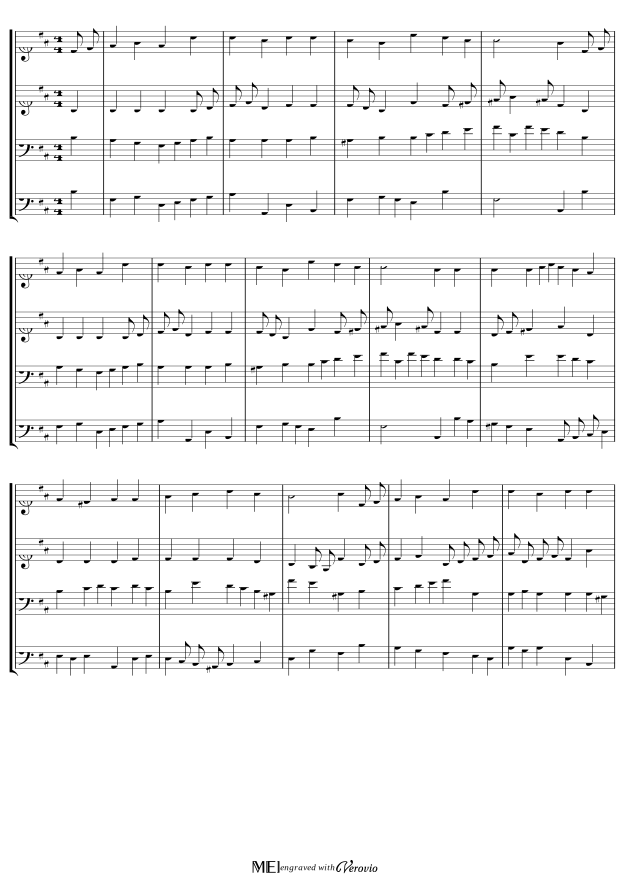

In [17]:
test_chorale.bars = [{"length":4,"nbars":1},{"length":16, "nbars":15},{"length":12, "nbars":1}]
test_chorale = test_chorale.addbars()
test_chorale_out = test_chorale.to_mei()
vrvtoolkit = toolkit()
vrvtoolkit.loadData(test_chorale_out)
vrvtoolkit.setScale(30)
display.SVG(vrvtoolkit.renderToSVG())

Pretty good, although verovio will only display one page at a time. Here's the missing ending.

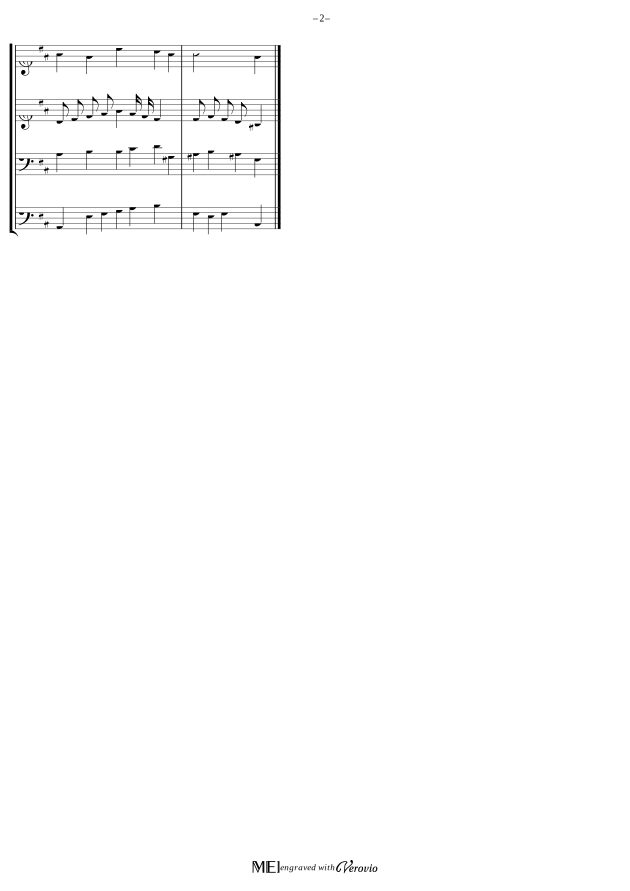

In [18]:
display.SVG(vrvtoolkit.renderToSVG(2))

Just for the sake of ease, let's turn all that into one method.

In [19]:
def displaysvg(self, bars=None, scale=30, page=1):
    out = self
    if bars is not None:
        out = self.copy().addbars(bars)
    tk = toolkit()
    tk.loadData(to_mei(out))
    tk.setScale(scale)
    return(display.SVG(tk.renderToSVG(page)))

Piece.displaysvg = displaysvg

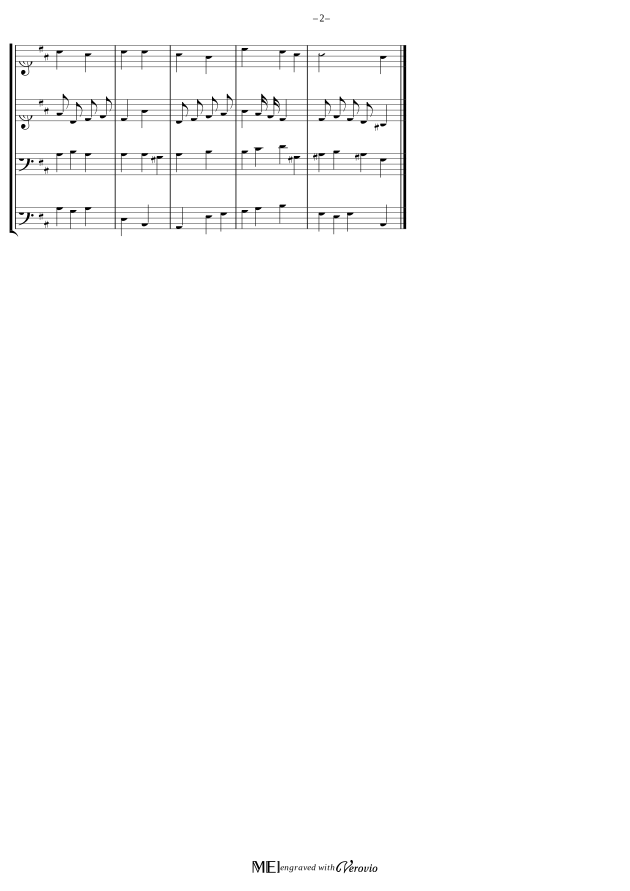

In [20]:
displaysvg(test_chorale, [{"length":4, "nbars":1},{"length":8,"nbars":30},{"length":12,"nbars":1}], page = 2)

Let's add a simple method while we're at it, to derive the bar structure from the units in the first line. This may be useful for generated pieces, but remember that the units will not always mean bars.

In [21]:
def getbars(self):
    #assumes at least one bar
    length = sum([n.length for n in self.notes[0][0]])
    out = [{"length": length, "nbars": 1}]
    for unit in self.notes[0]:
        runningtotal = 0
        for note in unit:
            runningtotal += note.length
        if runningtotal == out[-1]["length"]:
            out[-1]["nbars"] += 1
        else:
            out.append({"length":runningtotal, "nbars":1})
    return out

Piece.getbars = getbars


One thing might be particularly useful, and that is to represent pieces not by the specific notes, but by the intervals between them. That way two phrases that are simply transpositions of each other will look the same, except for the first note, without loss of any information. One thing we want to be wary of is rests, as it doesn't make sense for them to be considered an interval away from any particular note. However, we cannot leave them with pitch zero, as this now means a repeated note. So I've decided to call it pitch 100, which would be out of the range of any interval on the piano. I may come up with a better solution at some point, and alter this.

We could consider doing the same thing vertically, representing each note at a moment in time as an interval above its root. This requires a completely different structure for our notes attribute, and requires us to quantise everything down to the smallest rhythmic unit, so as to maintain synchronicity. That is what the *vertical* attribute has been for, to let us know which form the notes are kept in. Let's create tho

In [22]:
def to_vertical(self):
    working = self
    if self.intervallic:
        working = self.from_intervallic()
    quantised = working.quantise(1)
    out = []
    for i, unit in enumerate(quantised.notes[0]):
        out.append([])
        for j, note in enumerate(unit):
            out[i].append([quantised.notes[v][i][j] for v in range(len(quantised.notes))])
    piece = Piece(out)
    piece.copyattribs(self)
    piece.vertical = True
    piece.intervallic = False
    return piece

def to_horizontal(self):
    out = []
    for i, voice in enumerate(self.notes[0][0]):
        out.append([])
        for j, unit in enumerate(self.notes):
            out[i].append([])
            for k, chord in enumerate(unit):
                out[i][j].append(chord[i].copy())
    piece = Piece(out)
    piece.copyattribs(self)
    piece.vertical = False
    piece.intervallic = False
    return piece

Piece.to_vertical = to_vertical
Piece.to_horizontal = to_horizontal

In [23]:
def to_intervallic(self):
    out = self.copy()
    if self.vertical == False:
        for i, voice in enumerate(out.notes):
            prev_pitch = 0
            for j, unit in enumerate(voice):
                for k, note in enumerate(unit):
                    if note.pitch == 0:
                        note.pitch = 100
                    else:
                        note.pitch, prev_pitch = note.pitch - prev_pitch, note.pitch
    else:
        nvoices = len(out.notes[0][0])
        for i, unit in enumerate(out.notes):
            for j, chord in enumerate(unit):
                root = 0
                for k in range(nvoices-1,-1,-1):
                    if chord[k].pitch == 0:
                        chord[k].pitch = 100
                    elif root == 0:
                        root = chord[k].pitch
                    else:
                        chord[k].pitch = chord[k].pitch - root
                
    out.intervallic = True
    return out

Piece.to_intervallic = to_intervallic

def from_intervallic(self):
    out = self.copy()
    if self.vertical == False:
        for i, voice in enumerate(out.notes):
            prev_pitch = 0
            for j, unit in enumerate(voice):
                for k, note in enumerate(unit):
                    if note.pitch == 100:
                        note.pitch = 0
                    else:
                        note.pitch = prev_pitch + note.pitch
                        prev_pitch = note.pitch
    else:
        nvoices = len(out.notes[0][0])
        for i, unit in enumerate(out.notes):
            for j, chord in enumerate(unit):
                root = 0
                for k in range(nvoices-1,-1,-1):
                    if chord[k].pitch == 100:
                        chord[k].pitch = 0
                    elif root == 0:
                        root = chord[k].pitch
                    else:
                        chord[k].pitch = root + chord[k].pitch
    out.intervallic = False
    return out

Piece.from_intervallic = from_intervallic

Let's see what a vertical intervallic version of our chorale would look like.

In [24]:
print([str(n) for n in test_chorale.to_vertical().to_intervallic().notes[0][0]])

['7(1)t', '3(1)t', '0(1)t', '39(1)t']


We can see that the first semi-quaver in the choral has the bass singing a B, the tenor on the same note (i.e. zero semitones up), the alto the D above (three semitones, or a minor third), and the soprano the F sharp (seven semitones, or a perfect fifth). We might expect to see the 3, 7 combination a lot in these representations, forming a minor triad.

# What's next?

Well there are some cosmetic issues to sort out. I need to add beams to link groups of notes. And I need to derive more information from the imported score. But we have enough to do lots of interesting things with just this.

# To do:
- Sort out beams and accidental tracking for printing to a score.
- Add functionality for parts with more than one note (i.e. chords)
- Tuplets?
- Error handling for e.g. trying to perform tasks on vertically arranged pieces, or trying to make an intervallic piece vertical.
- OR/AND functionality for all methods for vertical and intervallic representations. 

Full file for reference purposes:

In [27]:
from numpy import mean, gcd
from datetime import date
import string, random
from verovio import toolkit
import xml.etree.ElementTree as ET
from IPython import display
import reference

class Note:
    def __init__(self, pitch: int, length: int):
        self.pitch = pitch #0-88
        self.length = length #number of ratoms, or rhythmic atoms. e.g. if the rhythmic atom is a semiquaver, a crotchet has length 16.

    def transpose(self, interval: int):
        out = self.copy()
        out.pitch += interval
        return out

    def __str__(self):
        return f"{self.pitch}({self.length})"

    def copy(self):
        return Note(self.pitch, self.length)

class NotePlus(Note):
    def __init__(self, pitch: int, length: int, tie=False):
        super().__init__(pitch, length)
        self.tie = tie

    def copy(self):
        return NotePlus(self.pitch, self.length, self.tie)

    def __str__(self):
        return super().__str__() + self.tie * "t"

class Piece:
    def __init__(self, notes=None, nvoices=0, ratom=16, metadata={}, vertical = False):
        self.metadata = metadata # e.g {"composer":"JS Bach", "title":"Chorale from Meine Seel erhebt den Herren", "opus": "BWV 10.7"}
        self.notes = notes if notes is not None else [[[]] for _ in range(nvoices)]
        self.bars = [] # e.g if a ratom is a semiquaver and the first bar is a crotchet long: [{"length":4, "n":1},{"length":12, "n":15},{"length":8, "n":1}]
        self.keysigs = [] # e.g. [{"ks":2s, "nbars":16}] for a 16 bar piece in D major with no key changes
        self.timesigs = [] # e.g. [{"ts":[4,4],"nbars":16}]
        self.annotations = {} # e.g. {"fermata":[[48,120],[48,120],[48,120],[48,120]], "dynamics":[{"f":0, "p":4, "dim":[0,4]},{...},{...},{...}], with an object for each part referring to indices of ratoms to which they are assigned
        self.ratom = ratom # the rhythmic atom, i.e. the smallest rhythmic unit used. The numbers are as used in time signatures, i.e. 16 is a semiquaver.
        self.clefs = [] # e.g. [{"shape":"G", "line":2},...]
        self.harm_key = {} # e.g. {"tonic":"g", "mode":"major"}
        self.intervallic = False
        self.vertical = vertical
    
    def copyattribs(self, source):
        self.bars = [bar.copy() for bar in source.bars]
        self.keysigs = [keysig.copy() for keysig in source.keysigs]
        self.harm_key = self.harm_key.copy()
        self.timesigs = [timesig.copy() for timesig in source.timesigs]
        self.clefs = [clef.copy() for clef in source.clefs]
        self.annotations = {k: [item.copy() for item in v] for k, v in source.annotations.items()}
        self.metadata = source.metadata.copy()
        self.ratom = source.ratom
        self.intervallic = source.intervallic
        self.vertical = source.vertical

    def transpose(self, interval: int):
        out = self.copy()
        out.copyattribs(self)
        for i,voice in enumerate(out.notes):
            for j, unit in enumerate(voice):
                for k, note in enumerate(unit):
                    note = self.notes[i][j][k].transpose(interval)
        return out

    def __str__(self):
        out = []
        for i, voice in enumerate(self.notes):
            out.append([])
            for j, sec in enumerate(voice):
                out[i].append([])
                for k, note in enumerate(sec):
                    out[i][j].append(str(note))
        return str(out)

    def copy(self):
        notescopy = [[[note.copy() for note in unit] for unit in voice] for voice in self.notes]
        out = Piece(notescopy)
        out.copyattribs(self)
        return out

    def getlength(self):
        total = 0
        for sec in self.notes[0]:
            for note in sec:
                total += note.length
        return total

    def getkeysigs(self):
        #placeholder: improve later to manage pieces with key signature changes
        out = "0s"
        maxratio = 0
        for ks in reference.diatonics:
            inorout = [0,0]
            for voice in self.notes:
                for unit in voice:
                    for note in unit:
                        if note.pitch in reference.diatonics[ks]:
                            inorout[0] +=1
                        else:
                            inorout[1] +=1
            inoutratio = inorout[0]/inorout[1]
            if inoutratio > maxratio:
                out = ks
                maxratio = inoutratio
        return [{"ks":out,"nbars":100}] #nbars arbitrary, as we assume there is only one key signature for this piece.

    def gettimesigs(self, ratom=16):
        #placeholder: improve later to work out more sensibel time signatures and manage piece with time signature changes
        if len(self.bars) == 0:
            barlength = sum([n.length for n in self.notes[0][1]]) if len(self.notes[0])>1 else sum([n.length for n in self.notes[0][0]])
        elif len(self.bars) == 1 or self.bars[0]["nbars"] != 1:
            barlength = self.bars[0]["length"]
        else:
            barlength = self.bars[1]["length"]
        ts = [barlength,ratom]
        while ts[1] > 4 and gcd(ts[0],ts[1]) > 1:
            ts = [ts[0] // 2,ts[1] // 2]
        return [{"ts":ts,"nbars":100}] #nbars again arbitrary.

    def getclefs(self):
        clefs = []
        for voice in self.notes:
            if mean([mean([n.pitch for n in unit]) for unit in voice]) < 42:
                clefs.append({"shape":"F", "line":4})
            else:
                clefs.append({"shape":"G", "line":2})
        return clefs

    def quantise(self, unitlength=4):
        notescopy = [[[note.copy() for note in unit] for unit in voice] for voice in self.notes]
        for i, voice in enumerate(notescopy):
            while len(voice) > 1:
                voice[0] += voice.pop(1)
            notescopy[i] = voice[0]
        quantised = []
        for i, voice in enumerate(notescopy):
            quantised.append([])
            unit, remainder = [], unitlength
            while len(voice) > 0:
                if voice[0].length == 0:
                    voice.pop(0)
                else:
                    length_to_add = min(remainder, voice[0].length)
                    tied = voice[0].tie if isinstance(voice[0],NotePlus) else voice[0].length > remainder
                    if isinstance(voice[0], NotePlus):
                        tied = voice[0].tie
                    if voice[0].length > remainder:
                        tied = True
                    if len(unit) > 0 and unit[-1].tie:
                        unit[-1].length += length_to_add
                        unit[-1].tie = tied
                    else:
                        unit.append(NotePlus(voice[0].pitch,length_to_add,tied))
                    remainder -= length_to_add
                    voice[0].length -= length_to_add
                    if remainder == 0:
                        quantised[i].append(unit)
                        unit, remainder = [], unitlength
            if sum([n.length for n in quantised[i][-1]]) < remainder:
                unit.append(NotePlus(0,remainder))
                quantised[i].append(unit)
                
        out = Piece(quantised)
        out.copyattribs(source=self)
        return out

    def concat(self, *args):
        out = self.copy()
        for piece in args:
            for i, voice in enumerate(piece.notes):
                self.notes[i].extend([[note.copy() for note in unit] for unit in voice])
        return out

    def addbars(self, bars=None):
        if bars is None:
            bars = self.bars
        quantised = self.quantise(1)
        out = Piece(nvoices=len(self.notes))
        startnote = 0
        for i, section in enumerate(bars):
            endnote = startnote+(section["length"]*section["nbars"])
            curr = Piece([[[note.copy() for note in unit] for unit in voice[startnote:endnote]] for voice in quantised.notes])
            curr = curr.quantise(section["length"])
            startnote = endnote
            if len(out.notes[0][0]) == 0:
                out = curr
            else:
                out.concat(curr)
        out.copyattribs(self)
        return out

    def to_mei(self,ratom=16):
        random.seed(str(self))
        def _idgen(): #generates a random string as an id for each element
            return 'id' + ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(10))
    
        bars = self.bars if len(self.bars) > 0 else [{"length":sum([n.length for n in self.notes[0][0]]),"nbars":1}]    
        title = "" if "title" not in self.metadata else self.metadata["title"]
        composer = "" if "composer" not in self.metadata else self.metadata["composer"]
        clefs = self.clefs if len(self.clefs) > 0 else getclefs(self)
        keysigs = self.keysigs if len(self.keysigs) > 0 else getkeysigs(self)
        timesigs = self.timesigs if len(self.timesigs) > 0 else gettimesigs(self,ratom)
        harm_key = self.harm_key if len(self.harm_key) > 0 else {"tonic":reference.sigtokeymap[keysigs[0]["ks"]][0],"mode":"major"}
        ties = [False for _ in self.notes]
        
        out = f"""<?xml version="1.0" encoding="UTF-8"?>
<?xml-model href="https://music-encoding.org/schema/5.0/mei-all.rng" type="application/xml" schematypens="http://relaxng.org/ns/structure/1.0"?>
<?xml-model href="https://music-encoding.org/schema/5.0/mei-all.rng" type="application/xml" schematypens="http://purl.oclc.org/dsdl/schematron"?>
<mei xmlns="http://www.music-encoding.org/ns/mei" meiversion="5.0">
    <meiHead xml:id="{_idgen()}">
        <fileDesc xml:id="{_idgen()}">
            <titleStmt xml:id="{_idgen()}">
                <title>{title}</title>
                <composer>{composer}</composer>
            </titleStmt>
            <pubStmt xml:id="{_idgen()}">
                <date>isodate="{str(date.today())}"></date>
            </pubStmt>
        </fileDesc>
        <encodingDesc xml:id="{_idgen()}">
            <appInfo xml:id="{_idgen()}">
                <application xml:id="{_idgen()}">
                    <name xml:id="{_idgen()}">Dunstaple</name>
                </application>
            </appInfo>
        </encodingDesc>
    </meiHead>
    <music>
        <body>
            <mdiv xml:id="{_idgen()}">
                <score xml:id="{_idgen()}">
                    <scoreDef xml:id="{_idgen()}">
                        <staffGrp xml:id="{_idgen()}" bar.thru="true">
                            <grpSym xml:id="{_idgen()}" symbol="bracket" />"""

        for i, voice in enumerate(self.notes):
            out += f"""
                            <staffDef xml:id="{_idgen()}" n="{i+1}" lines="5">
                                <clef xml:id="{_idgen()}" shape="{clefs[i]["shape"]}" line="{clefs[i]["line"]}" />
                                <keySig xml:id="{_idgen()}" sig="{keysigs[0]["ks"]}" />
                                <meterSig xml:id="{_idgen()}" count="{timesigs[0]["ts"][0]}" unit="{timesigs[0]["ts"][1]}" />
                            </staffDef>"""

        out += f"""
                        </staffGrp>
                    </scoreDef>
                    <section xml:id="{_idgen()}">
                        <pb xml:id="{_idgen()}" />"""
    
        bar_count = 0 if bars[0]["length"] < (ratom // timesigs[0]["ts"][1]) * timesigs[0]["ts"][0] else 1
        for i, bar in enumerate(self.notes[0]):
            currks=keysigs[0]["ks"]
            endbar = """right="end" """ if i == len(self.notes[0])-1 else ""
            out += f"""
                        <measure xml:id="{_idgen()}" {endbar}n="{bar_count}">"""
            for j, voice in enumerate(self.notes):
                out += f"""
                            <staff xml:id="{_idgen()}" n="{j+1}">
                                <layer xml:id="{_idgen()}" n="1">"""
                for k, note in enumerate(voice[i]):
                    if not isinstance(note, NotePlus):
                        note = NotePlus(note.pitch,note.length)
                    [pname,oct,accidges] = pitch_to_scientific(note.pitch).values()
                    [dur,dots] = lentodur(note.length).values()
                    tie_str = """tie="i" """ * note.tie + """tie="t" """ * ties[j]
                    ties[j] = note.tie
                    if note.pitch == 0:
                        out += f"""
                                    <rest xml:id="{_idgen()}" dots="{dots}" dur="{dur}" />"""
                        continue
                    accidges_str, accid_str = "", "/>"
                    need_accid, need_accidges = False, False
                    enharm = enharmonic({"pname":pname,"accid":accidges},ks=currks,mode=harm_key["mode"])
                    pname, accidges = enharm["pname"],enharm["accid"]
                    if (accidges == "s" and currks in reference.all_keysigs["flats"]) or (accidges =="f" and currks in reference.all_keysigs["sharps"]):
                        need_accid = True
                    elif (accidges == "s" and currks in reference.all_keysigs["sharps"]):
                        if pname not in reference.all_keysigs["sharps"][currks]:
                            need_accid = True
                        else:
                            need_accidges = True
                    elif (accidges == "f" and currks in reference.all_keysigs["flats"]):
                        if pname not in reference.all_keysigs["flats"][currks]:
                            need_accid = True
                        else:
                            need_accidges = True
                    elif (accidges == "n" and currks in reference.all_keysigs["flats"]):
                        if pname in reference.all_keysigs["flats"][currks]:
                            need_accid = True
                    elif (accidges == "n" and currks in reference.all_keysigs["sharps"]):
                        if pname in reference.all_keysigs["sharps"][currks]:
                            need_accid = True

                    if need_accidges:
                        accidges_str = f"""accid.ges="{accidges}" """
                    if need_accid:
                        accid_str = f""">
                                        <accid xml:id="{_idgen()}" accid="{accidges}" />
                                    </note>"""
                    out += f"""
                                    <note xml:id="{_idgen()}" dots="{dots}" dur="{dur}" oct="{oct}" pname="{pname}" {tie_str}{accidges_str}{accid_str}"""
                out += f"""
                                </layer>
                            </staff>"""
            out += f"""
                        </measure>"""
        out += f"""
                    </section>
                </score>
            </mdiv>
        </body>
    </music>
</mei>"""

        return out

    def displaysvg(self, bars=None, scale=30, page=1):
        out = self
        if bars is not None:
            out = self.copy().addbars(bars)
        tk = toolkit()
        tk.loadData(to_mei(out))
        tk.setScale(scale)
        return(display.SVG(tk.renderToSVG(page)))

    def getbars(self):
        #assumes at least one bar
        length = sum([n.length for n in self.notes[0][0]])
        out = [{"length": length, "nbars": 1}]
        for unit in self.notes[0]:
            runningtotal = 0
            for note in unit:
                runningtotal += note.length
            if runningtotal == out[-1]["length"]:
                out[-1]["nbars"] += 1
            else:
                out.append({"length":runningtotal, "nbars":1})
        return out

    def to_vertical(self):
        working = self
        if self.intervallic:
            working = self.from_intervallic()
        quantised = working.quantise(1)
        out = []
        for i, unit in enumerate(quantised.notes[0]):
            out.append([])
            for j, note in enumerate(unit):
                out[i].append([quantised.notes[v][i][j] for v in range(len(quantised.notes))])
        piece = Piece(out)
        piece.copyattribs(self)
        piece.vertical = True
        piece.intervallic = False
        return piece

    def to_horizontal(self):
        out = []
        for i, voice in enumerate(self.notes[0][0]):
            out.append([])
            for j, unit in enumerate(self.notes):
                out[i].append([])
                for k, chord in enumerate(unit):
                    out[i][j].append(chord[i].copy())
        piece = Piece(out)
        piece.copyattribs(self)
        piece.vertical = False
        piece.intervallic = False
        return piece

    def to_intervallic(self):
        out = self.copy()
        if self.vertical == False:
            for i, voice in enumerate(out.notes):
                prev_pitch = 0
                for j, unit in enumerate(voice):
                    for k, note in enumerate(unit):
                        if note.pitch == 0:
                            note.pitch = 100
                        else:
                            note.pitch, prev_pitch = note.pitch - prev_pitch, note.pitch
        else:
            nvoices = len(out.notes[0][0])
            for i, unit in enumerate(out.notes):
                for j, chord in enumerate(unit):
                    root = 0
                    for k in range(nvoices-1,-1,-1):
                        if chord[k].pitch == 0:
                            chord[k].pitch = 100
                        elif root == 0:
                            root = chord[k].pitch
                        else:
                            chord[k].pitch = chord[k].pitch - root
                    
        out.intervallic = True
        return out

    
    def from_intervallic(self):
        out = self.copy()
        if self.vertical == False:
            for i, voice in enumerate(out.notes):
                prev_pitch = 0
                for j, unit in enumerate(voice):
                    for k, note in enumerate(unit):
                        if note.pitch == 100:
                            note.pitch = 0
                        else:
                            note.pitch = prev_pitch + note.pitch
                            prev_pitch = note.pitch
        else:
            nvoices = len(out.notes[0][0])
            for i, unit in enumerate(out.notes):
                for j, chord in enumerate(unit):
                    root = 0
                    for k in range(nvoices-1,-1,-1):
                        if chord[k].pitch == 100:
                            chord[k].pitch = 0
                        elif root == 0:
                            root = chord[k].pitch
                        else:
                            chord[k].pitch = root + chord[k].pitch
        out.intervallic = False
        return out




def pitch_from_scientific(note,oct,accid = "n"):
    # translates to the number counting up from A1
    if note == "x":
        return 0
    map = {"c":4, "d":6, "e":8, "f":9, "g":11, "a":13, "b":15}
    basepitch = (oct-1)*12 + map[note]
    if accid == "n":
        return basepitch
    if accid == "s":
        return basepitch + 1
    if accid == "f":
        return basepitch - 1
    if accid == "ss":
        return basepitch + 2
    if accid == "ff":
        return basepitch - 2

def pitch_to_scientific(pitch):
    
    oct = (pitch + 8) // 12
    pname = reference.presumed_chr_scale[(pitch) % 12][0]
    accid = reference.presumed_chr_scale[(pitch) % 12][1]
    return {"pname":pname,"oct":oct,"accid":accid}

def durtolen(dur,dots=0,ratom=16):
    length = ratom * 2 if dur == 0 else ratom // dur
    duplength = length
    for _ in range(dots):
        duplength = duplength // 2
        length += duplength
    return length

def lentodur(note_len,ratom=16):
    if note_len == ratom * 2:
        return {"dur":0, "dots":0}
    dots = 0
    i, n = 0, ratom
    while n >=1:
        if note_len == n:
            break
        if note_len >= n:
            note_len -= n
            dots += 1
        i +=1
        n = n // 2
    dur = ratom // (n * 2 ** dots)                    
    return {"dur": dur,"dots": dots}

def from_mei(path,ratom=16):
    namespace = "{http://www.music-encoding.org/ns/mei}" #all tags will by default have the namespace attached at the front.
    tree = ET.parse(path)
        
    def _reststonotes(tree):
        # changes rests to notes with pname and oct 'x'
        for rest in tree.iter(namespace + 'rest'):
            rest.tag = namespace + 'note'
            rest.set("pname","x")
            rest.set("oct","-1")

    def _addaccidges(tree):
            for note in tree.iter(namespace+'note'):
                accid = note.find(namespace+'accid')
                if accid is not None:
                    val = accid.get('accid')
                    note.set('accid.ges', val)
           
    def _piecefromtree(tree):
        # yet to add functionality for reading metadata from mei
        nvoices=0
        for _ in tree.iter(namespace + 'staffDef'):
            nvoices += 1
        piece = Piece(nvoices=nvoices)
        ties = [False for _ in range(nvoices)]
        for ts in tree.iter(namespace + 'meterSig'):# Hacky. To be changed at some point to deal with pieces with more than one time signature.
            barlength = int(ts.get('count')) * ratom // int(ts.get('unit'))
            break
        rpts = [] #to keep track of repeats in order to copy out repeated notes twice
        for staffn in range(nvoices):
            rpts.append([])
            rptstart = 0
            for measure in tree.iter(namespace + 'measure'):
                if staffn == 0 and measure.get('left') == "rptstart":
                    rptstart = len(piece.notes[staffn][0])
                barrest = True
                for staff in measure.iter(namespace + 'staff'):
                    if int(staff.get('n')) == staffn + 1:
                        for note in staff.iter(namespace + 'note'):
                            barrest = False
                            dots = int(note.get('dots')) if note.get('dots') else 0
                            if ties[staffn]:
                                piece.notes[staffn][0][-1] += durtolen(int(note.get('dur')),dots,ratom)
                                ties[staffn] = False
                            else:
                                accid = note.get('accid.ges') if note.get('accid.ges') else "n"
                                newpitch = pitch_from_scientific(note.get('pname'), int(note.get('oct')), accid)
                                newlength = durtolen(int(note.get('dur')),dots,ratom)
                                piece.notes[staffn][0].append(Note(newpitch,newlength))
                            for tie in measure.iter(namespace + 'tie'):
                                if tie.get('startid') == note.get('id'):
                                    ties[staffn] = True
                                    break
                if measure.get('right') == "rptend":
                    rptendbarend = len(piece.notes[staffn][0])
                    rpts[staffn].append([rptstart, rptendbarend])
                if barrest:
                    piece.notes[staffn][0].append(Note(0, barlength))
        # Duplicate notes in repeated sections
        for i, voice in enumerate(piece.notes):
            for rpt_sec in rpts[i]:
                rpt_endindx = rpt_sec[1]
                voice[0][rpt_endindx:rpt_endindx] = [note.copy() for note in voice[0][rpt_sec[0]:rpt_endindx]]
            
        return piece
    _reststonotes(tree)
    _addaccidges(tree)
    return _piecefromtree(tree)

def enharmonic(sci_pitch,ks,mode="major"):
   
    guessed_tonic = reference.sigtokeymap[ks][0] if mode == "major" else reference.sigtokeymap[ks][1]
    out = dict(sci_pitch)
    note_tuple = (sci_pitch["pname"],sci_pitch["accid"])
    for eq_tuple in reference.enharm_equivs:
        if note_tuple in eq_tuple:
            if reference.leadingnotemap[guessed_tonic] in eq_tuple:
                out["pname"], out["accid"] = reference.leadingnotemap[guessed_tonic][0],reference.leadingnotemap[guessed_tonic][1]
                return out
    if ks in reference.all_keysigs["sharps"]:
        if sci_pitch["accid"] == "f":
            for eq_tuple in reference.enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) - 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
        else:
            return out
    elif ks in reference.all_keysigs["flats"]:
        if sci_pitch["accid"] == "s":
            for eq_tuple in enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) + 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
    return out
